## Model parameters selection

Select the parameters for Unet architecture to find first break picking time on the seismic trace.

* [The parameters studied](#The-parameters-studied)
* [Parameters value area](#Parameters-value-area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Dataset bypass](#Dataset-bypass)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

    
### The parameters studied
The number of UNet blocks and the number of filters and kernel size for encoder convolutions.

### Parameters value area
* _Number of Unet blocks_ - 4, 5, 6.

* _Encoder convolution kernel size_ - 3, 5
                       
### Metrics
Mean absolute error between predicted picking and target.

### Dataset loading
Dataset is given by SEGY file with a seismograms and CSV file with target picking time for this SEGY. The dataset contains 150 seismogramms. 

In [1]:
import sys
import numpy as np
from matplotlib import colors as mcolors

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, B, V, C, W
from seismicpro.batchflow.models.torch import UNet
from seismicpro.batchflow.utils import print_results, show_research
from seismicpro.batchflow.research import Research, Results, Option, RP, RI
from seismicpro.src import SeismicDataset, FieldIndex, TraceIndex, seismic_plot

First, we index field records:

In [2]:
path_raw ='/data/H2_PAL/FBP/H2_Pal_ETALON_150ffid.sgy'
markup_path = '/data/H2_PAL/FBP/H2_Pal_ETALON_150ffid_picking.csv'

index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

### Dataset bypass:
* Define model config
* Define index and train / test.

In [3]:
config = {
    'initial_block/inputs': 'raw',
    'inputs': {'masks': dict(classes=2), 'raw': dict(shape=B('raw').shape[1:])},
    'body/encoder/blocks': dict(kernel_size=C('kernel_size'), filters=C('filters')),
    'body/decoder/blocks': dict(kernel_size=C('kernel_size'), filters=C('filters')[::-1]),
    'body/embedding': dict(filters=C('filters')[-1] * 2, kernel_size=5),
    'optimizer': ('Adam', {'lr': 0.001}),
    'device': C('device'),
}

In [4]:
train_index = index.create_subset(index.indices[:120])
train_data = SeismicDataset(TraceIndex((train_index)))

test_index = index.create_subset(index.indices[120:])
test_data = SeismicDataset(TraceIndex((test_index)))

Create an instance of train and test pipelines.

In [5]:
B_SIZE = 2048
train_pipeline = (Pipeline()
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss')
                      .call(lambda batch: np.stack(batch.raw), save_to=B('raw'))
                      .call(lambda batch: np.stack(batch.mask), save_to=B('mask'))
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss',mode='w'))
                      .run_later(B_SIZE, n_epochs=None, drop_last=True, shuffle=21))

test_pipeline = (Pipeline()
                      .import_model('my_model', C('import_from'))
                      .init_variable('true', [])
                      .init_variable('predictions', [])
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .update(V('true', mode='a'), B('mask'))
                      .add_components(components='predictions')
                      .call(lambda batch: np.stack(batch.raw), save_to=B('raw'))
                      .call(lambda batch: np.stack(batch.mask), save_to=B('mask'))
                      .predict_model('my_model', B('raw'),
                                     fetches='predictions',  save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .update(V('predictions', mode='a'), B('predictions'))
                      .run_later(1024, n_epochs=1, drop_last=False, shuffle=False))

Define of auxiliary functions.

In [6]:
def mae(iteration, import_from):
    pipeline = import_from
    pred = np.hstack(np.concatenate(pipeline.get_variable('predictions')))
    true = np.argmax(np.stack(np.concatenate(pipeline.get_variable('true'))), axis=1)
    return np.mean(np.abs(true - pred))

### Creating a research object

Define the grid of parameters for search as well as research object.

In [7]:
grid = Option('filters', [[8, 16, 32, 64],
                          [8, 16, 32, 64, 128],
                          [8, 16, 32, 64, 128, 256]]) * Option('kernel_size', [3, 5]) 

In [8]:
research = (Research()
    .add_pipeline(train_pipeline, dataset=train_data, variables='loss', name='train')
    .add_pipeline(test_pipeline, dataset=test_data, name='test', run=True, execute=10, import_from=RP('train'))
    .init_domain(grid)
    .add_callable(mae, returns='mae', name='test_mae', execute=100, import_from=RP('test'), iteration=RI())
)

Now it's time to train research instance.

In [9]:
NUM_ITERS = 1000

research.run(NUM_ITERS, name='research', devices=[0, 1, 2, 3, 4, 5], bar=True)

Research research is starting...


Domain updated: 0: 100%|██████████| 6000/6000.0 [52:44<00:00,  1.90it/s] 


### Results

Loss functions vs a number of iterations for each parameters set:

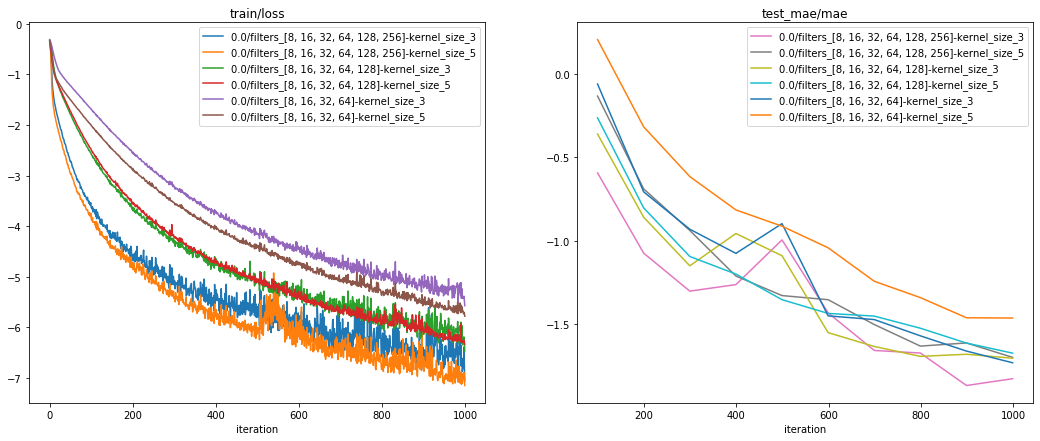

In [10]:
results = Results(path='research', concat_config=True)
show_research(results.df, layouts=['train/loss', 'test_mae/mae'], log_scale=True, color=list(mcolors.TABLEAU_COLORS.keys()))

Test metrics avaraged on the last 20 iterations.

In [11]:
print_results(results.df, 'test_mae/mae', True,ascending=True, n_last=20)

,mae (mean),mae (std)
"filters_[8, 16, 32, 64, 128, 256]-kernel_size_3",0.161071,0.0
"filters_[8, 16, 32, 64, 128, 256]-kernel_size_5",0.183039,0.0
"filters_[8, 16, 32, 64, 128]-kernel_size_3",0.182090,0.0
"filters_[8, 16, 32, 64, 128]-kernel_size_5",0.187710,0.0
"filters_[8, 16, 32, 64]-kernel_size_3",0.177200,0.0
"filters_[8, 16, 32, 64]-kernel_size_5",0.231645,0.0


### Conclusion

We can see, that the best quality shows model with following parameters:
* _Number of Unet blocks_ - 6.
* _Kernel size_ - 3.